EMAIL SPAM DETECTION WITH MACHINE LEARNING

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
import string
import nltk
from nltk.corpus import stopwords

In [ ]:
# Download NLTK data
nltk.download('stopwords')

# Custom transformer to clean text data
class TextCleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        return [self._clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def _clean_text(self, text):
        text = text.lower()
        text = ''.join([ch for ch in text if ch not in string.punctuation])
        words = text.split()
        words = [word for word in words if word not in stopwords.words('english')]
        return ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('/content/spam.csv', encoding='latin-1')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:

df.shape

(5572, 5)

In [ ]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [ ]:
# DROP UNNECESSARY COLUMNS
df.drop(columns=['Unnamed: 2' , 'Unnamed: 3' , 'Unnamed: 4'], inplace=True)
# RENAME COLUMNS FOR CLARITY
df.rename(columns={'v1':'target' , 'v2':'text'} , inplace='True')

# DISPLAY THE FIRST FEW ROWS AFTER DROPPING COLUMNS
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: title={'center': 'instances vs classes'}, xlabel='no of instances', ylabel='classes'>

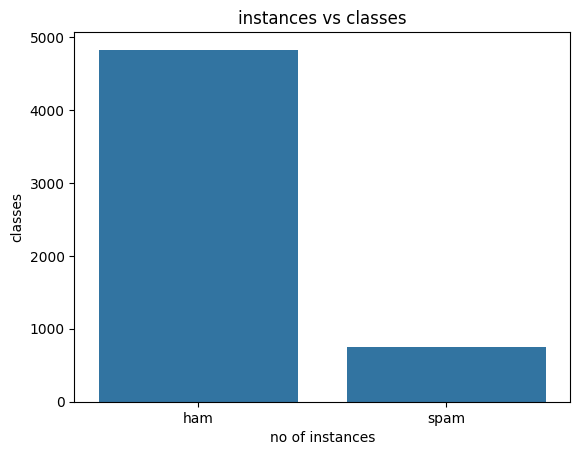

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sbn
plt.title("instances vs classes")
plt.xlabel("no of instances")
plt.ylabel("classes")
sbn.barplot(x=["ham","spam"],y=[df["target"].value_counts()["ham"],df["target"].value_counts()["spam"]])

In [ ]:
df['target'] = df['target'].map({'spam': 1, 'ham': 0})

In [ ]:
df.duplicated().sum()

403

In [ ]:
# DROP DUPLICATE ROWS FROM THE DATASET
df = df.drop_duplicates(keep='first')
df.duplicated().sum()


0

In [ ]:
df.shape

(5169, 2)

In [ ]:
print(df['target'].value_counts())

target
0    4516
1     653
Name: count, dtype: int64


In [ ]:
X = df['text']
Y = df['target']


In [ ]:
from sklearn.model_selection import train_test_split

# SPLIT THE DATA INTO TRAINING AND TEST SETS
X_train , X_test , Y_train , Y_test = train_test_split(X,Y , test_size=0.2 ,random_state=2)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Building models and pipeline for Decision Tree, Random Forest, and Naive Bayes
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': MultinomialNB()
}

best_model = None
best_accuracy = 0
best_model_name = ""

for model_name, model in models.items():
    pipeline = Pipeline([
        ('cleaner', TextCleaner()),
        ('vectorizer', TfidfVectorizer()),
        ('classifier', model)
    ])

    pipeline.fit(X_train, Y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)

    print(f"{model_name} Model:")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(Y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))
    print("\n")

    # Check if the current model has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline


Decision Tree Model:
Accuracy: 0.9477756286266924
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       896
           1       0.86      0.73      0.79       138

    accuracy                           0.95      1034
   macro avg       0.91      0.86      0.88      1034
weighted avg       0.95      0.95      0.95      1034

Confusion Matrix:
 [[879  17]
 [ 37 101]]


Random Forest Model:
Accuracy: 0.9680851063829787
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       896
           1       1.00      0.76      0.86       138

    accuracy                           0.97      1034
   macro avg       0.98      0.88      0.92      1034
weighted avg       0.97      0.97      0.97      1034

Confusion Matrix:
 [[896   0]
 [ 33 105]]


Naive Bayes Model:
Accuracy: 0.9545454545454546
Classification Report:
               precision    recall  f1-

In [ ]:
# Save the best model using pickle
with open('best_spam_detector.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best Model: {best_model_name} with Accuracy: {best_accuracy}")

Best Model:  with Accuracy: 0.9680851063829787


In [ ]:
# Function to load the best model
def load_best_model():
    with open('best_spam_detector.pkl', 'rb') as file:
        model = pickle.load(file)
    return model

# Function to preprocess text
def preprocess_text(text):
    cleaner = TextCleaner()
    cleaned_text = cleaner.transform([text])
    return cleaned_text[0]

# Function to predict using the best model
def predict_with_best_model(text, model):
    # Preprocess text
    preprocessed_text = preprocess_text(text)

    # Predict using the best model
    prediction = model.predict([preprocessed_text])[0]

    return prediction

# Example usage
if __name__ == "__main__":
    # Load the best model
    best_model = load_best_model()

    # Example sentences to test
    sentences = [
        "Congratulations! You've won a free cruise. Claim your prize now!",
        "Click this link to earn money fast!",
        "URGENT: Your account has been compromised. Click here to secure it."
    ]

    # Predict and print results
    for sentence in sentences:
        prediction = predict_with_best_model(sentence, best_model)

        print(f"Sentence: {sentence}")
        print(f"Prediction: {'Spam' if prediction == 1 else 'Not Spam'}")
        print()

Sentence: Congratulations! You've won a free cruise. Claim your prize now!
Prediction: Spam

Sentence: Click this link to earn money fast!
Prediction: Not Spam

Sentence: URGENT: Your account has been compromised. Click here to secure it.
Prediction: Not Spam

